# Fine-tuning InceptionV3 for food nutrition classifier

In [17]:
import tensorflow as tf
#suppress "INFO:tensorflow:Summary name .... is illegal; using ... instead." warnings.
tf.logging.set_verbosity(tf.logging.WARN)

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dropout
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from download import download_file
import os.path
import numpy as np

### Database parameters

In [18]:
# Set metadata database paths
download_file('https://s3-eu-west-1.amazonaws.com/redbase/data.sqlite', 'data.sqlite')
database_path = 'data.sqlite'

# Set image database paths
download_file('https://s3-eu-west-1.amazonaws.com/redbase/image_data_299.sqlite', 'image_data_299.sqlite')
image_data_database_path = 'image_data_299.sqlite'

# Index cache
condition_indeces = None

#Set the id of classification stored in the database which will be used to train model.
classification_id = 11

File already downloaded (size: 174744576)
File already downloaded (size: 7500314624)


### Training parameters

In [37]:
# Limit number of images per class used for training and validating.
train_max = 750
val_max = 750
test_max = 750

# Image dimensions (Inception input size)
img_width, img_height = 299, 299

# Set batch size to biggest that fits in your memory.
batch_size = 256

# Number of epochs to train top inception network blocks.
top_epochs = 2

# Number of epochs to fine tune the network.
fit_epochs = 20

### Name the run

In [20]:
# Name the current parameters set. This name will be used as a Tensorboard log directory subfolder.
# having separate subfolder for each run will allow you to conviniently view performance changes beween runs.

run_name = "cid%d_tm%d_vm%d_bs%d_te%d_te%d" % (classification_id, 
                                               train_max, val_max, 
                                               batch_size, top_epochs, 
                                               fit_epochs)

print ("Run name: %s" % run_name)

Run name: cid11_tm750_vm750_bs256_te50_te50


### Initializing 

In [21]:
# Import custom SQLite data reader
from sqlite_data_loader import SQLiteDataLoader

sdl = SQLiteDataLoader(database_path, image_data_database_path)

# Load the number of nutrition classes
class_count = len(sdl.get_condition_indeces(classification_id))

print ("Number of nutrition classes: %d" % class_count)

Number of nutrition classes: 25


In [22]:
# Get the number of train and validation samples
nb_train_samples = 0
train_pr = 0.7
nb_validation_samples = 0
valid_pr = 0.3
nb_test_samples = 0
test_pr = 0.00

for ci in sdl.get_condition_indeces(classification_id):
    nb_train_samples += sdl.get_image_count_by_condition_index(ci, classification_id, train_pr, train_max)
    nb_validation_samples += sdl.get_image_count_by_condition_index(ci, classification_id, valid_pr, val_max)
    nb_test_samples += sdl.get_image_count_by_condition_index(ci, classification_id, test_pr, test_max)

print ("Train samples: %d" % nb_train_samples)
print ("Validation samples: %d" % nb_validation_samples)
print ("Test samples: %d" % nb_test_samples)

Class 0 has 58266 images.
Class 1 has 36703 images.
Class 2 has 34386 images.
Class 3 has 92852 images.
Class 4 has 7091 images.
Class 5 has 14208 images.
Class 6 has 1866 images.
Class 7 has 2988 images.
Class 8 has 1336 images.
Class 9 has 14319 images.
Class 10 has 9046 images.
Class 11 has 23630 images.
Class 12 has 34143 images.
Class 13 has 8237 images.
Class 14 has 13262 images.
Class 15 has 4064 images.
Class 16 has 4952 images.
Class 17 has 3401 images.
Class 18 has 8412 images.
Class 19 has 13109 images.
Class 20 has 9839 images.
Class 21 has 2063 images.
Class 22 has 1165 images.
Class 23 has 6086 images.
Class 24 has 534 images.
Train samples: 12973
Validation samples: 5560
Test samples: 0


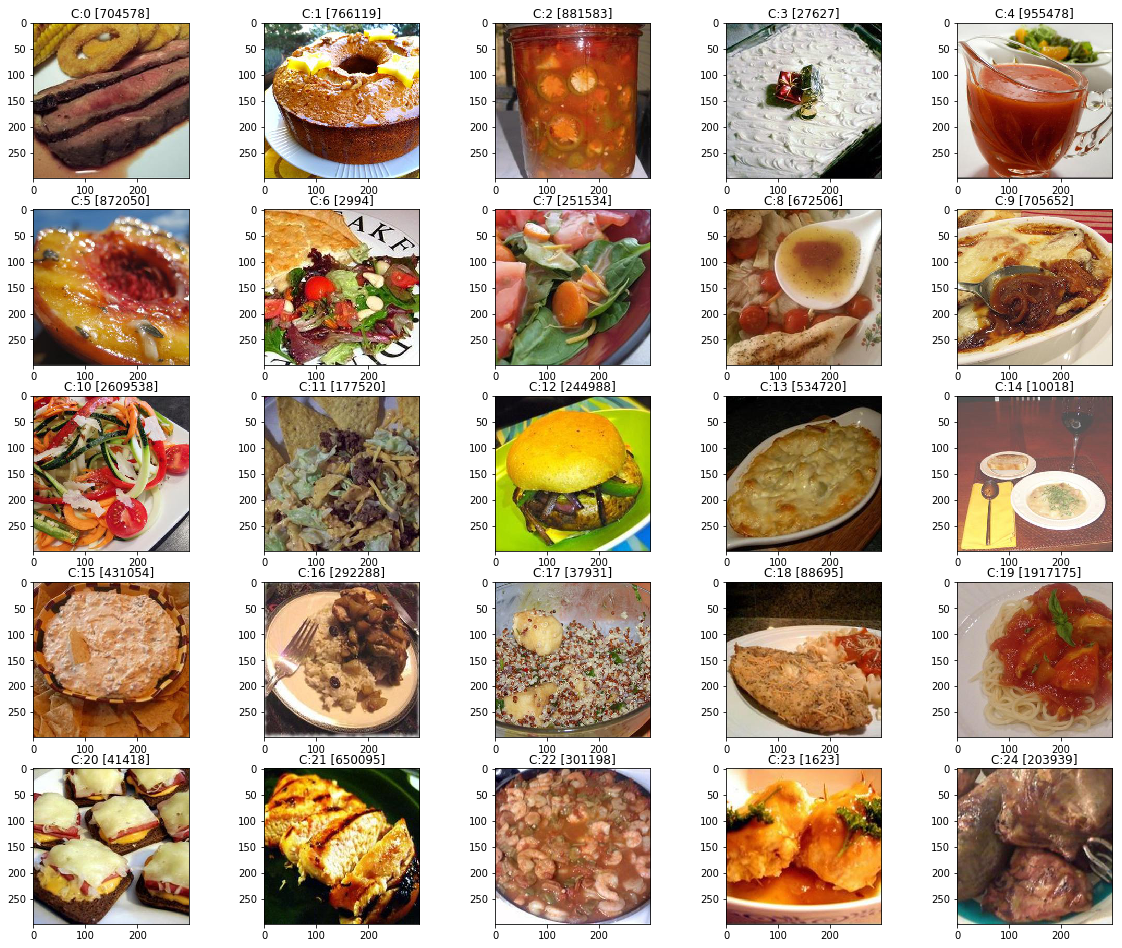

In [39]:
"""
Show an image for each nutrition class. 
"""

from image_ex import load_img_bytes
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))
columns = 5

for ci in range(class_count):
    image_id = sdl.get_image_ids_by_condition_index(ci, classification_id, 0, 1)[0]
    image_data = sdl.get_image_data_by_id(image_id)
    pil_img = load_img_bytes(image_data)
    
    sp = fig.add_subplot(class_count / columns + 1, columns, ci + 1)
    sp.set_title('C:%d [%d]'%(ci, image_id))
    plt.imshow(pil_img)
    

## Visualize recipe classification

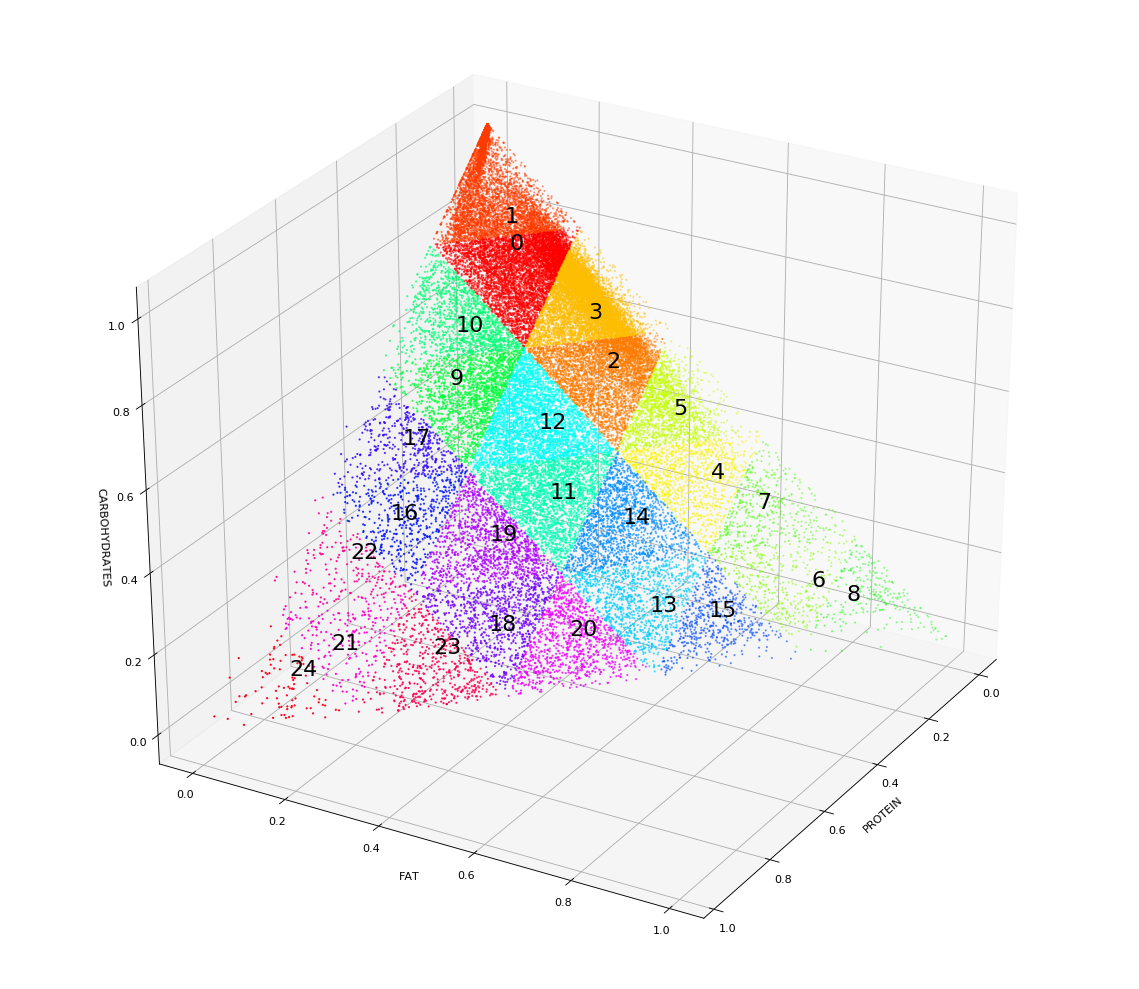

In [24]:
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

ax = plt.axes(projection='3d')

ax.view_init(30, 30)

rates = np.array(sdl.get_nutrition_values(classification_id))

# Data for three-dimensional scattered points
rates_x = rates[:,0]
rates_y = rates[:,1]
rates_z = rates[:,2]

rates_c = rates[:,3]
rates_c /= class_count

ax.scatter3D(rates_x, rates_y, rates_z, c=rates_c, cmap='hsv', s=1);

ax.set_xlabel('PROTEIN')
ax.set_ylabel('FAT')
ax.set_zlabel('CARBOHYDRATES')

centroids = np.array(sdl.get_centroids(classification_id)) 

for cd in centroids:
    ax.text(cd[0],cd[1],cd[2],  '%d' % cd[3], size=20, zorder=1, color='k') 

## Building the model

In [25]:
# Set checkpoint save files
top_layers_checkpoint_path = 'cp.top.%s.hdf5' % run_name
fine_tuned_checkpoint_path = 'cp.ftuned.%s.hdf5' % run_name
new_extended_inception_weights = 'weights.%s.hdf5' % run_name

print ("Top layer train checkpoint: %s" % top_layers_checkpoint_path)
print ("Fine tune checkpoint: %s" % fine_tuned_checkpoint_path)
print ("Final weights: %s" % new_extended_inception_weights)

Top layer train checkpoint: cp.top.cid11_tm750_vm750_bs256_te50_te50.hdf5
Fine tune checkpoint: cp.ftuned.cid11_tm750_vm750_bs256_te50_te50.hdf5
Final weights: weights.cid11_tm750_vm750_bs256_te50_te50.hdf5


In [26]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer    # ADDED BY ME
x = Dense(1024, activation='relu')(x)  # ADDED BY ME
# let's add a dropout regularization   # ADDED BY ME
x = Dropout(0.4)(x)                    # ADDED BY ME
# let's add a second fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- we have 125 classes
predictions = Dense(class_count, activation='softmax')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

if os.path.exists(top_layers_checkpoint_path):
    model.load_weights(top_layers_checkpoint_path)
    print ("Checkpoint '" + top_layers_checkpoint_path + "' loaded.")

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'], )

/home/aind2/anaconda3/envs/recipes/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Checkpoint 'cp.top.cid11_tm750_vm750_bs256_te50_te50.hdf5' loaded.


### Setup data generators

In [28]:
# Import custom image data generator capable of taking lamda function to load data from SQLite 
from image_ex import ImageDataGeneratorEx

# prepare data augmentation configuration
train_datagen = ImageDataGeneratorEx(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGeneratorEx(rescale=1. / 255)

train_generator = train_datagen.flow_from_database(
    get_class_array=(lambda: sdl.get_condition_indeces(classification_id)),
    get_image_count_by_class=(lambda ci: sdl.get_image_count_by_condition_index(ci, classification_id, train_pr, train_max)),
    get_image_ids_by_class=(lambda ci: sdl.get_image_ids_by_condition_index(ci, classification_id, 0, sdl.get_image_count_by_condition_index(ci, classification_id, train_pr, train_max))),
    get_image_data_by_id=(lambda image_id: sdl.get_image_data_by_id(image_id)),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_database(
    get_class_array=(lambda: sdl.get_condition_indeces(classification_id)),
    get_image_count_by_class=(lambda ci: sdl.get_image_count_by_condition_index(ci, classification_id, valid_pr, val_max)),
    get_image_ids_by_class=(lambda ci: sdl.get_image_ids_by_condition_index(ci, classification_id, sdl.get_image_count_by_condition_index(ci, classification_id, train_pr, train_max), sdl.get_image_count_by_condition_index(ci, classification_id, valid_pr, val_max))),
    get_image_data_by_id=(lambda image_id: sdl.get_image_data_by_id(image_id)),
    batch_size=batch_size,
    class_mode='categorical')

Found 12973 images belonging to 25 classes.
Found 5560 images belonging to 25 classes.


In [29]:
#Save the model after every epoch.
mc_top = ModelCheckpoint(top_layers_checkpoint_path, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

#Save the TensorBoard logs.
tb = TensorBoard(log_dir=('./logs/%s'%run_name), histogram_freq=1, write_graph=True, write_images=True)

In [30]:
# train the model on the new data for a few epochs
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=top_epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[mc_top, tb])

Epoch 1/2
50/50 [==============================] - 244s - loss: 2.2848 - acc: 0.3391 - val_loss: 2.9654 - val_acc: 0.1722
Epoch 2/2
50/50 [==============================] - 191s - loss: 2.1474 - acc: 0.3723 - val_loss: 2.9826 - val_acc: 0.1778


At this point, the top layers are well trained and we can start fine-tuning convolutional layers from inception V3. We will freeze the bottom N layers and train the remaining top layers.

In [31]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_2
1 conv2d_95
2 batch_normalization_95
3 activation_95
4 conv2d_96
5 batch_normalization_96
6 activation_96
7 conv2d_97
8 batch_normalization_97
9 activation_97
10 max_pooling2d_5
11 conv2d_98
12 batch_normalization_98
13 activation_98
14 conv2d_99
15 batch_normalization_99
16 activation_99
17 max_pooling2d_6
18 conv2d_103
19 batch_normalization_103
20 activation_103
21 conv2d_101
22 conv2d_104
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_100
29 conv2d_102
30 conv2d_105
31 conv2d_106
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_110
42 batch_normalization_110
43 activation_110
44 conv2d_108
45 conv2d_111
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_107
52 conv2d_109
53 co

In [32]:
# Save the model after every epoch.
mc_fit = ModelCheckpoint(fine_tuned_checkpoint_path, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# Load saved wights
if os.path.exists(fine_tuned_checkpoint_path):
    model.load_weights(fine_tuned_checkpoint_path)
    print ("Checkpoint '" + fine_tuned_checkpoint_path + "' loaded.")


In [33]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

In [34]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
#model.fit_generator(...)

In [35]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=fit_epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[mc_fit, tb])

model.save_weights(new_extended_inception_weights)

Epoch 1/10
50/50 [==============================] - 256s - loss: 2.0857 - acc: 0.3821 - val_loss: 2.9549 - val_acc: 0.1765
Epoch 2/10
50/50 [==============================] - 247s - loss: 2.0372 - acc: 0.3964 - val_loss: 2.9354 - val_acc: 0.1810
Epoch 3/10
50/50 [==============================] - 246s - loss: 2.0075 - acc: 0.4068 - val_loss: 2.9554 - val_acc: 0.1801
Epoch 4/10
50/50 [==============================] - 247s - loss: 1.9737 - acc: 0.4166 - val_loss: 2.9409 - val_acc: 0.1795
Epoch 5/10
50/50 [==============================] - 248s - loss: 1.9685 - acc: 0.4150 - val_loss: 2.9247 - val_acc: 0.1816
Epoch 6/10
50/50 [==============================] - 246s - loss: 1.9549 - acc: 0.4205 - val_loss: 2.9452 - val_acc: 0.1814
Epoch 7/10
50/50 [==============================] - 246s - loss: 1.9310 - acc: 0.4227 - val_loss: 2.9631 - val_acc: 0.1789
Epoch 8/10
50/50 [==============================] - 246s - loss: 1.9305 - acc: 0.4268 - val_loss: 2.9655 - val_acc: 0.1765
Epoch 9/10
50/50

In [ ]:
model.load_weights(new_extended_inception_weights)

from keras.preprocessing import image as kpi

print(image_id)
img = load_img_bytes(sdl.get_image_data_by_id(image_id))
img_tensor = kpi.img_to_array(img)

print(img_tensor.shape)

print(np.expand_dims(img_tensor, axis=0).shape)
print (model.predict(np.expand_dims(img_tensor, axis=0)))
print (np.argmax(model.predict(np.expand_dims(img_tensor, axis=0))))

tot = 0
correct = 0
for ci in range(class_count):
    image_ids = sdl.get_image_ids_by_condition_index(ci, classification_id, 0, val_max)
    list_of_tensors = [np.expand_dims(kpi.img_to_array(load_img_bytes(sdl.get_image_data_by_id(ii))), axis=0) for ii in image_ids]
    batch = np.vstack(list_of_tensors)    
    
    for ii, prediction in zip(image_ids, model.predict(batch)):
        tot += 1
        if ci == np.argmax(prediction): 
            correct +=1
    print ("(val acc: %f)" % (correct/tot))
print ("val acc: %f" % (correct/tot))

203939
(299, 299, 3)
(1, 299, 299, 3)
[[  1.39797429e-28   0.00000000e+00   6.30323257e-06   9.99993682e-01
    0.00000000e+00   0.00000000e+00   7.97703567e-36   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]]
3
(val acc: 0.057333)
(val acc: 0.028667)
(val acc: 0.192444)
(val acc: 0.273000)
(val acc: 0.218400)
(val acc: 0.182000)
(val acc: 0.158095)
(val acc: 0.138333)
(val acc: 0.122963)
(val acc: 0.110667)
(val acc: 0.100606)
(val acc: 0.092222)
(val acc: 0.085128)
(val acc: 0.079048)
(val acc: 0.073778)
(val acc: 0.069167)
(val acc: 0.065098)
(val acc: 0.061481)
(val acc: 0.058246)
(val acc: 0.055400)
(val acc: 0.052762)
(val acc: 0.050364)
(val acc: 0.048174)
